<a href="https://colab.research.google.com/github/jodog0412/COMPETITION/blob/main/SHOPPING_REGRESSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 환경설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab/SHOPPING_PRODUCT_ANALYSIS
!ls

/content/drive/MyDrive/Colab/SHOPPING_PRODUCT_ANALYSIS
'[Baseline]_1. 데이터 분석 입문자를 위한 데이터 분석 & 예측.ipynb'
'[Baseline]_2. 랜덤 포레스트를 사용한 데이터 분석 & 예측.ipynb'
 dataset
 SHOPPING_DATA_ANALYSIS_BEGINNER.ipynb
 submission.csv


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
CFG = {
    'IMG_SIZE':28*28, #이미지 사이즈
    'EPOCHS':10000, #에포크
    'LEARNING_RATE':1e-2, #학습률
    'BATCH_SIZE':100, #배치사이즈
}

#2. 데이터 처리

In [ ]:
import pandas as pd
import numpy as np

# 데이터 로드
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')
sample_submission = pd.read_csv('./dataset/sample_submission.csv')

train.describe()

,id,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Weekly_Sales
count,6255.000000,6255.000000,6255.000000,6255.000000,2102.000000,1592.000000,1885.000000,1819.000000,2115.000000,6255.000000,6.255000e+03
mean,3128.000000,23.000000,60.639199,3.344369,7155.930661,3308.125810,1462.535523,3465.952501,4518.993173,8.029236,1.047619e+06
std,1805.807299,12.988211,18.624094,0.455364,8408.206085,9382.823804,9667.580258,6413.116294,6048.661908,1.874875,5.654362e+05
min,1.000000,1.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.410000,135.160000,4.077000,2.099862e+05
25%,1564.500000,12.000000,47.170000,2.917000,1844.295000,39.755000,4.700000,499.895000,1742.305000,6.916500,5.538695e+05
50%,3128.000000,23.000000,62.720000,3.413000,5221.140000,205.410000,24.600000,1532.630000,3226.410000,7.906000,9.604761e+05
75%,4691.500000,34.000000,75.220000,3.722000,9199.242500,1931.005000,104.010000,3640.905000,5444.030000,8.622000,1.421209e+06
max,6255.000000,45.000000,100.140000,4.308000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,14.313000,3.818686e+06


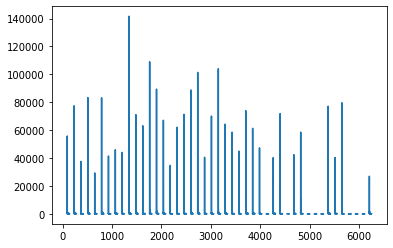

In [ ]:
plt.plot(train['Promotion3'])

## 1) train 전처리

In [ ]:
# 결측치 처리
train=train.fillna(0)

# Date 전처리
def date_encoder(date):
    day, month, year = map(int, date.split('/'))
    return day, month, year
train['Month'] = train['Date'].apply(lambda x: date_encoder(x)[1])
train['Year'] = train['Date'].apply(lambda x: date_encoder(x)[2])
# isHoliday column에서의 true, false는 1과 0으로 자동처리됨.

import sklearn.preprocessing as sca

# 정규화
scaler = sca.RobustScaler()
scaler.fit(train[['Promotion1',
                  'Promotion2',
                  'Promotion3',
                  'Promotion4',
                  'Promotion5']])
scaled = scaler.transform(train[['Promotion1',
                                 'Promotion2',
                                 'Promotion3',
                                 'Promotion4',
                                 'Promotion5']])
train[['Scaled_Promotion1','Scaled_Promotion2',
       'Scaled_Promotion3','Scaled_Promotion4',
       'Scaled_Promotion5']] = scaled

# 분석할 의미가 없는 칼럼을 제거합니다.
X = train.drop(columns=['id','Date','Weekly_Sales'])
X = X.drop(columns=['Promotion1',
                    'Promotion2',
                    'Promotion3',
                    'Promotion4',
                    'Promotion5'])
Y = train[['Weekly_Sales']]
X.describe()

,Store,Temperature,Fuel_Price,Unemployment,Month,Year,Scaled_Promotion1,Scaled_Promotion2,Scaled_Promotion3,Scaled_Promotion4,Scaled_Promotion5
count,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6.255000e+03,6255.000000,6255.000000,6255.000000
mean,23.000000,60.639199,3.344369,8.029236,6.345324,2010.935252,1.254700,8.419722e+03,157.691633,5.274054,0.852289
std,12.988211,18.624094,0.455364,1.874875,3.227195,0.788547,3.094591,4.947042e+04,1913.567917,19.879417,2.295585
min,1.000000,-2.060000,2.472000,4.077000,1.000000,2010.000000,0.000000,-2.657600e+03,-10.411449,0.000000,0.000000
25%,12.000000,47.170000,2.917000,6.916500,4.000000,2010.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
50%,23.000000,62.720000,3.413000,7.906000,6.000000,2011.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
75%,34.000000,75.220000,3.722000,8.622000,9.000000,2012.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000
max,45.000000,100.140000,4.308000,14.313000,12.000000,2012.000000,46.252092,1.045195e+06,50672.847943,353.068128,60.529767


## 2) test 전처리

In [ ]:
# 결측치 처리
test = test.fillna(0)
# Date 전처리
test['Month'] = test['Date'].apply(lambda x: date_encoder(x)[1])
test['Year'] = test['Date'].apply(lambda x: date_encoder(x)[2])
# 정규화
scaled = scaler.transform(test[['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5']])
test[['Scaled_Promotion1','Scaled_Promotion2',
       'Scaled_Promotion3','Scaled_Promotion4',
       'Scaled_Promotion5']] = scaled
test = test.drop(columns=['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5'])
test = test.drop(columns=['id','Date'])
test

,Store,Temperature,Fuel_Price,Unemployment,IsHoliday,Month,Year,Scaled_Promotion1,Scaled_Promotion2,Scaled_Promotion3,Scaled_Promotion4,Scaled_Promotion5
0,1,68.55,3.617,6.573,False,10,2012,4.214698,0.0,6.518784,18.928523,2.022584
1,1,62.99,3.601,6.573,False,10,2012,1.088480,0.0,2.901610,3.151902,3.305649
2,1,67.97,3.594,6.573,False,10,2012,0.495842,0.0,1.763864,0.419915,1.290059
3,1,69.16,3.506,6.573,False,10,2012,1.349186,317.5,2.146691,5.531683,0.727907
4,2,70.27,3.617,6.170,False,10,2012,3.150245,0.0,3.592129,15.840982,2.149345
...,...,...,...,...,...,...,...,...,...,...,...,...
175,44,46.97,3.755,5.217,False,10,2012,0.020166,26.1,0.350626,0.000000,0.255318
176,45,64.89,3.985,8.667,False,10,2012,2.633173,0.0,6.733453,11.791272,1.305208
177,45,54.47,4.000,8.667,False,10,2012,1.020703,0.0,2.822898,3.135995,2.225839
178,45,56.47,3.969,8.667,False,10,2012,1.045612,0.0,1.137746,2.290461,0.857580


# 3. 모델링

## 1) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

model = RandomForestRegressor()
x_train,x_eval,y_train,y_eval=train_test_split(X,Y,test_size=0.2,random_state=42)
model.fit(x_train,y_train.values.ravel())
predict=model.predict(x_eval)
print(mean_squared_error(y_eval,predict))
print(model.score(x_train,y_train))

18872629888.881966
0.9912991642737937


## 2) Multi Layer Perceptrons

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=torch.nn.Sequential(
            nn.Linear(12,16),
            nn.ReLU()
        )
        self.layer2=torch.nn.Sequential(
            nn.Linear(16,32),
            nn.ReLU()
        )
        self.layer3=torch.nn.Sequential(
            nn.Linear(32,64),
            nn.ReLU()
        )
        self.out=torch.nn.Sequential(
            nn.Linear(64,1)
        )
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        output=self.out(x)
        return output


[0] Train loss: 1406739152896.00000
[100] Train loss: 309124333568.00000
[200] Train loss: 303428665344.00000
[300] Train loss: 297720152064.00000
[400] Train loss: 290929836032.00000
[500] Train loss: 321329299456.00000
[600] Train loss: 262830817280.00000
[700] Train loss: 260466458624.00000
[800] Train loss: 262378143744.00000
[900] Train loss: 258383822848.00000
[1000] Train loss: 257903247360.00000
[1100] Train loss: 257544159232.00000
[1200] Train loss: 257249198080.00000
[1300] Train loss: 256875462656.00000
[1400] Train loss: 350647222272.00000
[1500] Train loss: 257092878336.00000
[1600] Train loss: 256464617472.00000
[1700] Train loss: 256021250048.00000
[1800] Train loss: 255821053952.00000
[1900] Train loss: 255666667520.00000
[2000] Train loss: 255500533760.00000
[2100] Train loss: 255353946112.00000
[2200] Train loss: 255198216192.00000
[2300] Train loss: 255555174400.00000
[2400] Train loss: 254868094976.00000
[2500] Train loss: 254725668864.00000
[2600] Train loss: 2545

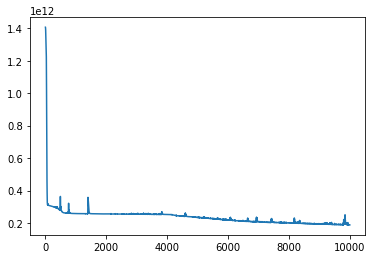

In [ ]:
import matplotlib.pyplot as plt
model=MLP().to(device)
criterion=nn.MSELoss().to(device)
optimizer=optim.Adam(model.parameters(),lr=CFG["LEARNING_RATE"])
x_train_T=torch.Tensor(x_train.values.astype(np.float64))
y_train_T=torch.Tensor(y_train.values.astype(np.float64))
losses=[]
def train(model,optimizer):
    model.train()
    for epoch in range(CFG["EPOCHS"]):
        running_loss=0.0
        pred=model(x_train_T.cuda())
        loss=criterion(pred,y_train_T.cuda())
        optimizer.zero_grad() #배치마다 optimizer 초기화
        loss.backward() #손실함수 기준 역전파 
        optimizer.step() #가중치 최적화
        running_loss += loss.item()
        losses.append(running_loss)
        if epoch%100==0:
            print('[%d] Train loss: %.5f' %(epoch, running_loss))
    plt.plot(list(range(CFG["EPOCHS"])),losses)
train(model,optimizer)

In [ ]:
sample_submission['Weekly_Sales'] = prediction.detach().numpy()
sample_submission.head()
sample_submission.to_csv('submission.csv',index = False)